team work: Somayyeh Eslami- Maryam Bagherirad

# Lab 3 - Logistic Regression

In this lab we implement and use logistic regressione for binary claffication problems.

We start including some libraries and functions already seen in the previous labs (or slight variations of them). Have a look and verify you understand their purpose.

<b>READ all the text parts very carefully, as you will find instructions on how to proceed.</b>

In [4]:
# import libraries
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
import math

In [5]:
def mixGauss(means, sigmas, n):
    """
    means : 2D array (num_classes, d)
        Each row of the array gives the mean of the Gaussian in multiple dimensions for one class.
        For binary classification problems, the number of rows should be 2!
    sigmas : 1D array (num_classes)
        The standard deviation for the Gaussian distribution of each class (isotropic Gaussian!)
    
    Example:
    
    >>> means = [[3, 0], [0, 0]]
    >>> sigmas = [0.5, 1]
    >>> X, Y = mixGauss(means, sigmas, n=100)
    >>> fig, ax = plt.subplots()
    >>> ax.scatter(X[Y == 1,0], X[Y == 1,1], marker='o', color='r')
    >>> ax.scatter(X[Y == -1,0], X[Y == -1,1], marker='o', color='b')
    """
    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

In [8]:
def flipLabels(Y, perc):
    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

In [10]:
def separatingFLR(Xtr, Ytr, Ypred, w):
    fig, ax = plt.subplots()
    xi = np.linspace(Xtr[:, 0].min(), Xtr[:, 0].max(), 200)
    yi = np.linspace(Xtr[:, 1].min(), Xtr[:, 1].max(), 200)
    X, Y = np.meshgrid(xi,yi)
    
    zi = griddata(Xtr, Ypred, (X,Y), method='linear')
    
    ax.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    ax.scatter(Xtr[:,0], Xtr[:,1], c=Ytr, marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(Xtr[:,0].min(), Xtr[:,0].max())
    ax.set_ylim(Xtr[:,1].min(), Xtr[:,1].max())

## Linear logistic regression with gradient descent

We define two functions:
 - the `optimal_gd_learning_rate(Xtr, reg_par)` function calculates the optimal learning rate for GD on a given dataset. You will need to use the SVD of the covariance matrix.
 - the `train_logreg_gd(Xtr, Ytr, reg_par, maxiter)` function estimates the classifier weights on the training set.

<br>

The parameters of the `optimal_gd_learning_rate` function are:
- <b>Xtr</b> is the nxD matrix of training set inputs
- <b>reg_par</b> is the value of the lammbda

and it should output the learning rate $\gamma$ (a scalar).
You should use the `np.linalg.eigvalsh` function to calculate the eigenvalues of the covariance matrix.

<br>

The parameters of the `train_logreg_gd` function are:
- <b>Xtr</b> is the nxD matrix of training set inputs
- <b>Ytr</b> is the n vector of training set outputs
- <b>reg_par</b> is the value of the lammbda
- <b>maxiter</b> is the maximum number of iterations to run gradient descent

and it should output:
- <b>w</b> is the D vector of the estimated function parameters
- <b>losses</b> is the vector of the loss at each iteration


In [13]:
def optimal_gd_learning_rate(Xtr, reg_par):
    # Estimate the gamma parameter: the optimal learning rate for gradient descent
    eigvals = np.linalg.eigvalsh(Xtr.T @ Xtr)
    L = np.max(eigvals) / Xtr.shape[0] + 2 * reg_par
    gamma = 1 / L
    return gamma

def train_logreg_gd(Xtr, Ytr, reg_par, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    maxiter : the maximum number of gradient-descent iterations
    """
    # Epsilon is a criterion for early stopping
    epsilon = 1e-6
    
    # size of the input in the training
    n, D = np.shape(Xtr)
    
    # initialization of the vector w
    w = np.zeros((D, 1))
    
    # Set the learning rate optimally
    gamma = optimal_gd_learning_rate(Xtr, reg_par)
    
    # initialization of some supporting variables
    j=0
    loss_old = 0
    loss = float("inf")
    training_losses = np.zeros(maxiter + 1)
    Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
    while j < maxiter and abs(loss - loss_old) >= epsilon:
        loss_old = loss
       
        w = w - gamma * (...)
        loss = ...
        training_losses[j] = loss[0]
        j = j + 1
    return w, training_losses[:j]


In [16]:
def train_logreg_gd(Xtr, Ytr, reg_par, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    maxiter : the maximum number of gradient-descent iterations
    """
    # Epsilon is a criterion for early stopping
    epsilon = 1e-6
    
    # Size of the input in the training
    n, D = np.shape(Xtr)
    
    # Initialization of the vector w
    w = np.zeros((D, 1))
    
    # Set the learning rate optimally
    gamma = optimal_gd_learning_rate(Xtr, reg_par)
    
    # Initialization of some supporting variables
    j = 0
    loss_old = 0
    loss = float("inf")
    training_losses = np.zeros(maxiter + 1)
    Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1

    while j < maxiter and abs(loss - loss_old) >= epsilon:
        loss_old = loss
        
        # Calculate predictions using the sigmoid function
        z = Xtr @ w
        predictions = 1 / (1 + np.exp(-z))
        
        # Compute the loss with L2 regularization (logistic loss)
        loss = -np.mean(Ytr * np.log(predictions) + (1 - Ytr) * np.log(1 - predictions)) \
               + (reg_par / 2) * np.sum(w ** 2)
        
        # Calculate gradient of the loss function
        gradient = (Xtr.T @ (predictions - Ytr)) / n + reg_par * w
        
        # Update the weights
        w = w - gamma * gradient
        
        # Store the loss for this iteration
        training_losses[j] = loss
        j += 1

    return w, training_losses[:j]


### Evaluation the function on the test set

A function to perform predictions on a set of samples given the learned logistic regression weights

##### Ypred, Ppred = predict_logreg(weights, Xte)
where
- <b>weights</b> is the D vector of the estimated function parameters
- <b>X</b> is the matrix of input points of the training or test set.
- <b>Ypred</b> is the vector of predictions
- <b>Ppred</b> is the predicted probability of a point belonging to class +1. It will be 0 if the model is very confident the point belongs to class -1, it will be 1 if the model is very confident that the point belongs to class +1.

In [19]:
def predict_logreg(weights, X):
    """
    weights : array of shape d, 1
    X : array of shape n, d
    """
    ypred = np.dot(X, weights)
    # Try and understand what it does, deriving the formula
    ppred = 1 / (1 + np.exp(-ypred))
    # The outputs are reshaped to be 1D vectors.
    return ypred.reshape(-1), ppred.reshape(-1)

In [21]:
def calcError(Ypred, Y):
    class_err = np.mean(np.sign(Ypred) != Y)
    return class_err

## Initial Analysis

Perform the following tasks for the initial analysis:

1. Create two binary classification datasets (training and test sets) -- Use the same parameters. Visualize them in a scatter plot.

2. Pick a reasonable value for lambda (e.g. reg_par = 0.1, 0.01, 0.001, ...) and train a logistic-regression model using the functions you have defined.

3. Plot the loss at each iteration which is returned by the training function. The loss should decrease at each iteration, **if the loss does not decrease there is an error in the implementation!**

4. Use the `separatingFLR` function to plot the separating curve obtained with the model

5. Evaluate the error training and test sets.

**Important #1**: The parameters used to generate the data are quite important. Try to make sure that the two classes are distinct (i.e. the means of the Gaussians should be different), but also not too far. Ideally a few points should overlap between the classes.
Make sure to generate at least 100 points for both train and test sets.

**Important #2**: since we are implementing a linear model, we must add a bias term -- otherwise the weights will draw a line which always goes through 0. An alternative to adding a bias term to the model is to add a feature comprising all ones to the data-column. We can use the following code for this:
```
Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))
```
what whill be the resulting shape of the weight vector `w`?

# Help for data-generation
means = ...
sigmas = ...

Xtr, Ytr = ...
Xts, Yts = ...

Xtr_wbias = ... 
Xts_wbias = ...

# TODO: Plot training and test sets, coloring the two classes differently.
fig = plt.figure(figsize=(7, 4))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

ax0.set_title("Training set")
ax0.scatter(Xtr[:,0], Xtr[:,1], s=70, c=Ytr, alpha=0.8)

ax1.set_title("Test set")
ax1.scatter(Xts[:,0], Xts[:,1], s=70, c=Yts, alpha=0.8)

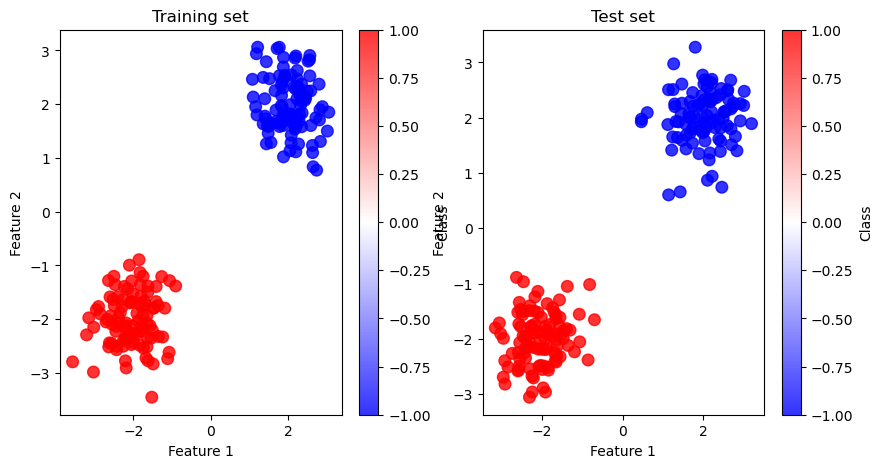

In [25]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt

# Step 1: Define means and sigmas for generating binary classification data
means = [[2, 2], [-2, -2]]   # Means for two classes, separated but with some overlap
sigmas = [0.5, 0.5]          # Standard deviation (same for both classes)

# Step 2: Generate the training and test datasets
n_samples = 100  # Number of samples per class

# Generate training data
Xtr, Ytr = mixGauss(means, sigmas, n_samples)
# Generate test data
Xts, Yts = mixGauss(means, sigmas, n_samples)

# Step 3: Add bias term to training and test data
Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

# Step 4: Plot training and test sets
fig = plt.figure(figsize=(10, 5))

# Training set plot
ax0 = fig.add_subplot(1, 2, 1)
ax0.set_title("Training set")
scatter_train = ax0.scatter(Xtr[:,0], Xtr[:,1], s=70, c=Ytr, cmap="bwr", alpha=0.8)
ax0.set_xlabel("Feature 1")
ax0.set_ylabel("Feature 2")
plt.colorbar(scatter_train, ax=ax0, label="Class")

# Test set plot
ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title("Test set")
scatter_test = ax1.scatter(Xts[:,0], Xts[:,1], s=70, c=Yts, cmap="bwr", alpha=0.8)
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
plt.colorbar(scatter_test, ax=ax1, label="Class")

plt.show()


In [32]:
# TODO: Plot the losses

C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_16156\24178853.py:35: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(Ytr * np.log(predictions) + (1 - Ytr) * np.log(1 - predictions)) \
C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_16156\24178853.py:35: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(Ytr * np.log(predictions) + (1 - Ytr) * np.log(1 - predictions)) \


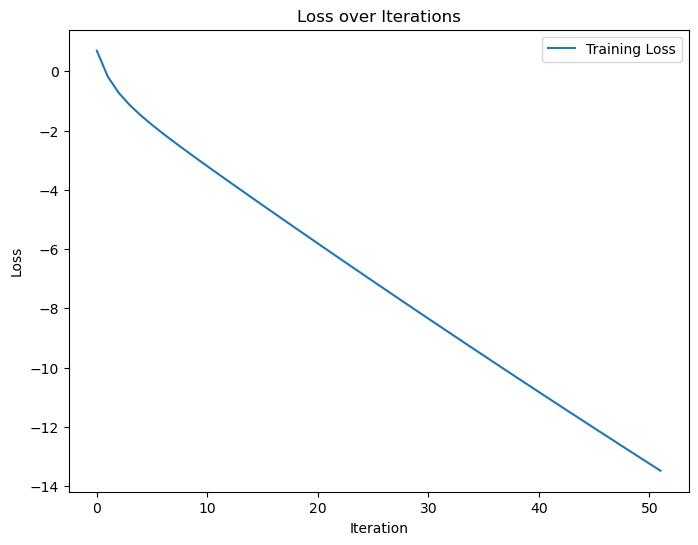

In [27]:
reg_par = 0.01  # Regularization parameter
maxiter = 1000  # Maximum number of iterations for gradient descent
weights, losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter)
plt.figure(figsize=(8, 6))
plt.plot(losses, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations")
plt.legend()
plt.show()


In [ ]:
# TODO: Plot the separating curve (on the test set)

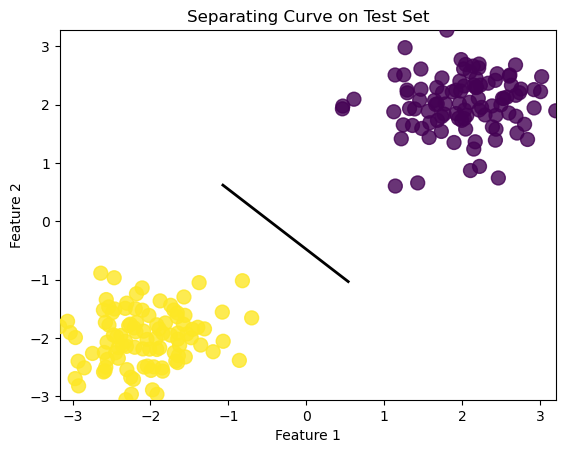

In [29]:
Ypred_test, _ = predict_logreg(weights, Xts_wbias)
separatingFLR(Xts, Yts, Ypred_test, weights)
plt.title("Separating Curve on Test Set")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


# TODO: Evaluate the errors
#separatingFLR(Xtr, Ytr, Ypred, w)
tr_pred, _ = predict_logreg(...)
tr_err = calcError(...)
ts_pred, _ = predict_logreg(...)
ts_err = calcError(...)
print("Training error: %.2f%%, Test error: %.2f%%" % (tr_err * 100, ts_err * 100))

In [32]:

tr_pred, _ = predict_logreg(weights, Xtr_wbias)
tr_err = calcError(tr_pred, Ytr)
ts_pred, _ = predict_logreg(weights, Xts_wbias)
ts_err = calcError(ts_pred, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (tr_err * 100, ts_err * 100))


Training error: 0.00%, Test error: 0.00%


## Interpreting the confidence of logistic regression predictions

Logistic regression does not only output *pointwise predictions* (the class to which a point belongs), but it also gives the **probability** that a test point belongs to a certain class.

This probability can be very useful to interpret the outputs of your model: in certain cases it might be better to **not predict anything** if the confidence of the model is low (i.e. if the model predicts a probability of 0.5 in a binary setting, the model is not sure which class a point belongs to).

In this part of the lab, we will
 1. Implement a function which allows to visualize the confidence of predictions (`plot_logreg_confidence`)
 2. Train a logistic regression model, and use the visualization function to see where the low confidence region of prediction lies.
 3. Calculate the error on **just the high-confidence** predictions, and see how the it changes.

In [35]:
def plot_logreg_confidence(X, Y, pred_confidence, threshold):
    """
    X : a (n, d) dataset
    Y : a (n, ) array of targets
    pred_confidence : A (n, ) array of probabilities predicted from X
    threshold : a float between 0 and 0.5 determining the probability threshold we use to 
                consider neutral predictions. For example if threshold=0.1 then all probabilities
                between 0.4 and 0.6 will be considered neutral (that is, neither belonging to class +1
                or to class -1).
    """
    fig, ax = plt.subplots()
    xi = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
    yi = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
    X_grid, Y_grid = np.meshgrid(xi,yi)
    
    zi = griddata(X, pred_confidence, (X_grid, Y_grid), method='linear')
    
    ax.contour(xi, yi, zi, 15, linewidths=2, levels=[0.5 - threshold, 0.5 + threshold])
    
    # Plot data points
    ax.scatter(X[:,0], X[:,1], c=Y, 
               marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(X[:,0].min(), X[:,0].max())
    ax.set_ylim(X[:,1].min(), X[:,1].max())

In [37]:
# Generate some data
Xtr, Ytr = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)
Xts, Yts = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

# TODO: Train a logistic regression model, and obtain the probability predictions for the test set
...
ts_pred, ts_conf = predict_logreg(...)
# TODO: Plot the logistic regression confidence for different thresholds. Interpret what you see.


Plotting with threshold: 0.1

Plotting with threshold: 0.2

Plotting with threshold: 0.3


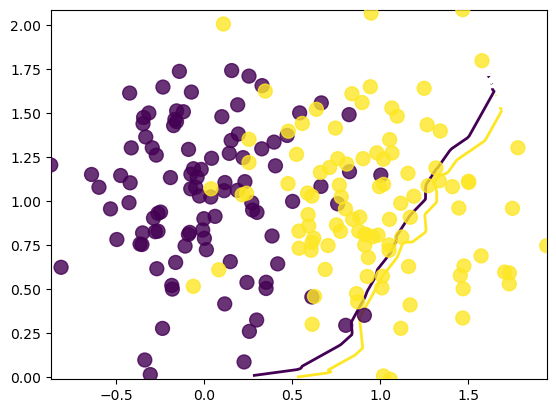

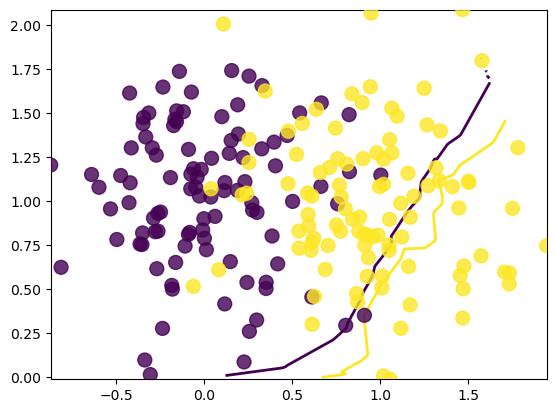

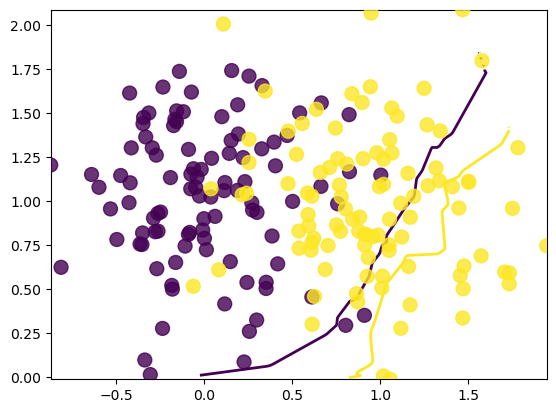

In [40]:
# Step 1: Train the Logistic Regression Model
reg_par = 0.01  # Set a reasonable regularization parameter
maxiter = 1000  # Set the maximum number of iterations for gradient descent

# Train the model on the training set with bias term
weights, losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter)

# Step 2: Obtain Probability Predictions for the Test Set
# Predict on the test set to get both predictions and confidence (probability)
ts_pred, ts_conf = predict_logreg(weights, Xts_wbias)

# Step 3: Plot the Logistic Regression Confidence for Different Thresholds
# Define a list of thresholds to visualize the effect on confidence
thresholds = [0.1, 0.2, 0.3]  # Example thresholds between 0 and 0.5

# Plot confidence regions for each threshold
for threshold in thresholds:
    print(f"\nPlotting with threshold: {threshold}")
    plot_logreg_confidence(Xts, Yts, ts_conf, threshold=threshold)


In [42]:
def calc_error_with_confidence(prob_pred, Y, threshold):
    """
    Calculate the classification error on only the predictions with a high confidence!
    """
    class_m1 = prob_pred <= 0.5 - threshold
    class_p1 = prob_pred > 0.5 + threshold
    
    err_class_m1 = Y[class_m1] != -1
    err_class_p1 = Y[class_p1] != 1
    return (np.sum(err_class_m1) + np.sum(err_class_p1)) / (len(err_class_m1) + len(err_class_p1))

In [69]:
# TODO: Train a log-reg model, and calculate the error on only the high-confidence examples from the test
#       set. How do you expect this error to behave as you change the threshold?

In [44]:
reg_par = 0.01 
maxiter = 1000  

weights, losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter)
_, ts_conf = predict_logreg(weights, Xts_wbias)

thresholds = [0.1, 0.2, 0.3]  

for threshold in thresholds:
    high_conf_error = calc_error_with_confidence(ts_conf, Yts, threshold)
    print(f"High-confidence error rate at threshold {threshold:.2f}: {high_conf_error * 100:.2f}%")


High-confidence error rate at threshold 0.10: 38.27%
High-confidence error rate at threshold 0.20: 37.63%
High-confidence error rate at threshold 0.30: 37.23%


## Logistic Regression with Stochastic Gradient Descent

SGD is quite similar to GD, but instead of updating the weights with the gradient of all the training samples at once, at each step it updates the weights with the **gradient of a single sample** picked at random from the training set.

Since at each iteration it uses a single sample it will be much faster, but it will need more iterations.

In this last part you will:
 1. Implement a SGD solver for logistic regression
 2. Use it to learn a logistic-regression model
 3. Compare the results to learning with GD.

def train_logreg_sgd(Xtr, Ytr, reg_par, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    maxiter : the maximum number of gradient-descent iterations
    """
    epsilon = 1e-6
    # size of the input in the training
    n, D = np.shape(Xtr)
    # initialization of the vector w
    w = np.zeros((D, 1))
    
    # initialization of some supporting variables
    training_losses = np.zeros(maxiter)
    Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
    for j in range(maxiter):
        # The learning rate here is different from GD. You can take
        # a) 1 / sqrt(n)
        # b) 1 / sqrt(j) : the learning rate decreases at each iteration.
        # Which one do you expect leads to faster convergence?
        gamma = 1 / np.sqrt(n)
        
        # TODO: Choose the sample current stample from Xtr **at random**
        sample_idx = ...
        
        # TODO: Use the formulas from the slides to update the weight vector
        w = w - gamma * (...)
        # TODO: Calculate the loss on the current sample.
        loss = ...
        training_losses[j] = loss
        
        if j > 0 and abs(training_losses[j] - training_losses[j-1]) < epsilon:
            break
        
    return w, training_losses[:j]

In [50]:
import numpy as np

def train_logreg_sgd(Xtr, Ytr, reg_par, maxiter=100):
    """
    Xtr : array of shape (n, d), training data with bias term
    Ytr : array of shape (n,), training labels
    reg_par : regularization parameter (a scalar)
    maxiter : the maximum number of gradient-descent iterations
    """
    epsilon = 1e-6
    # Size of the input in the training set
    n, D = np.shape(Xtr)
    # Initialize the weight vector
    w = np.zeros((D, 1))
    
    # Array to store the training loss at each iteration
    training_losses = np.zeros(maxiter)
    Ytr = Ytr.reshape(-1, 1)  # Convert Ytr to shape (n, 1) if it's not already

    for j in range(maxiter):
        # Learning rate for SGD; can also use gamma = 1 / np.sqrt(j+1) for a decaying rate
        gamma = 1 / np.sqrt(n)
        
        # Select a random sample from the training set
        sample_idx = np.random.randint(n)
        x_i = Xtr[sample_idx].reshape(1, -1)  # Single sample input
        y_i = Ytr[sample_idx]                 # Corresponding label

        # Calculate the prediction for the sample using the sigmoid function
        z = np.dot(x_i, w)
        prediction = 1 / (1 + np.exp(-z))
        
        # Compute the gradient for this sample
        gradient = (prediction - y_i) * x_i.T + reg_par * w

        # Update the weights using the computed gradient
        w = w - gamma * gradient

        # Calculate the logistic loss for the current sample (optional, for tracking)
        loss = - (y_i * np.log(prediction + 1e-10) + (1 - y_i) * np.log(1 - prediction + 1e-10)) \
               + (reg_par / 2) * np.sum(w ** 2)
        training_losses[j] = loss[0]

        # Early stopping condition
        if j > 0 and abs(training_losses[j] - training_losses[j-1]) < epsilon:
            break

    return w, training_losses[:j+1]


In [52]:
# TODO: Generate a dataset (use the code from the previous parts)

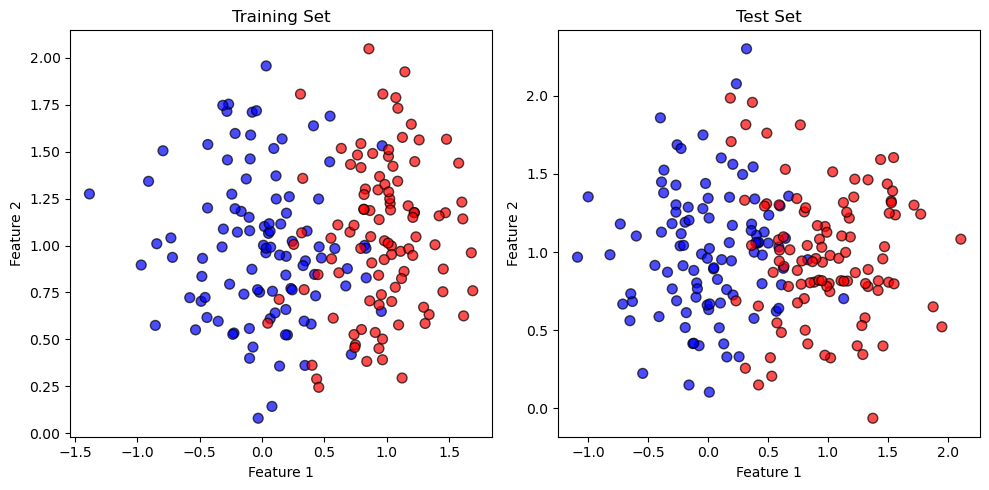

In [54]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

means = [[0, 1], [1, 1]]   
sigmas = [0.4, 0.4]        
n_samples = 100           


Xtr, Ytr = mixGauss(means, sigmas, n_samples)


Xts, Yts = mixGauss(means, sigmas, n_samples)


Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))


plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.scatter(Xtr[:, 0], Xtr[:, 1], c=Ytr, cmap="bwr", edgecolors='k', s=50, alpha=0.7)
plt.title("Training Set")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")


plt.subplot(1, 2, 2)
plt.scatter(Xts[:, 0], Xts[:, 1], c=Yts, cmap="bwr", edgecolors='k', s=50, alpha=0.7)
plt.title("Test Set")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()


In [56]:
# TODO: Train logistic regression with SGD
# TODO: Train logistic regression with GD

C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_16156\2743019513.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  training_losses[j] = loss[0]


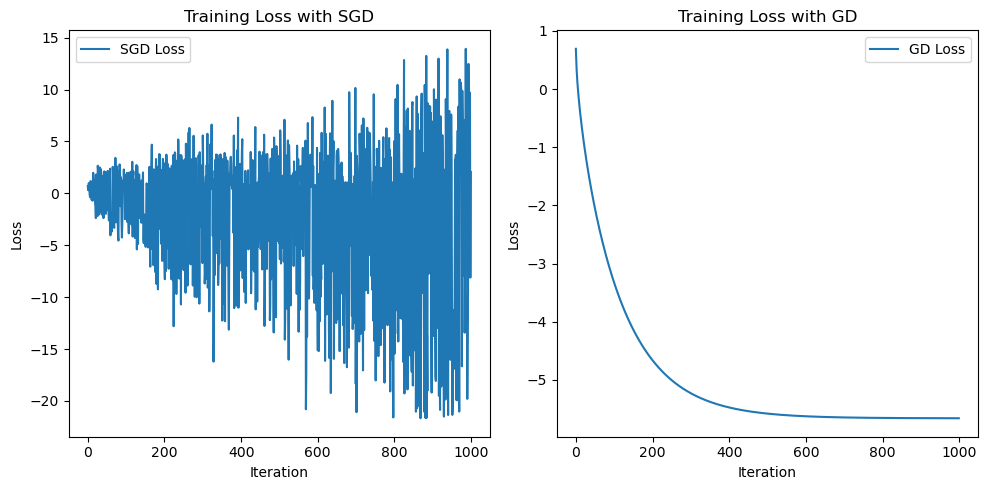

Final weights from SGD:
 [[14.12538288]
 [-6.42472344]
 [-8.80377932]]
Final weights from GD:
 [[ 26.24294188]
 [-11.99863553]
 [-16.71499596]]


In [58]:

reg_par = 0.01  
maxiter = 1000  
gamma = 1 / np.sqrt(Xtr_wbias.shape[0])  


w_sgd, losses_sgd = train_logreg_sgd(Xtr_wbias, Ytr, reg_par, maxiter=maxiter)

w_gd, losses_gd = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter)

w_gd, losses_gd = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter)

plt.figure(figsize=(10, 5))

# Plot SGD Loss
plt.subplot(1, 2, 1)
plt.plot(losses_sgd, label="SGD Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss with SGD")
plt.legend()

# Plot GD Loss
plt.subplot(1, 2, 2)
plt.plot(losses_gd, label="GD Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss with GD")
plt.legend()

plt.tight_layout()
plt.show()

print("Final weights from SGD:\n", w_sgd)
print("Final weights from GD:\n", w_gd)


In [ ]:
# TODO: Compare the two in terms of:
#  1. number of iterations needed to converge (keep in mind that GD iterations cost n times more)
#  2. accuracy.

C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_16156\2743019513.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  training_losses[j] = loss[0]


SGD iterations to converge: 1000
GD iterations to converge: 1000 (GD iteration costs 200 times more)
SGD Test Set Accuracy: 67.00%
GD Test Set Accuracy: 70.00%


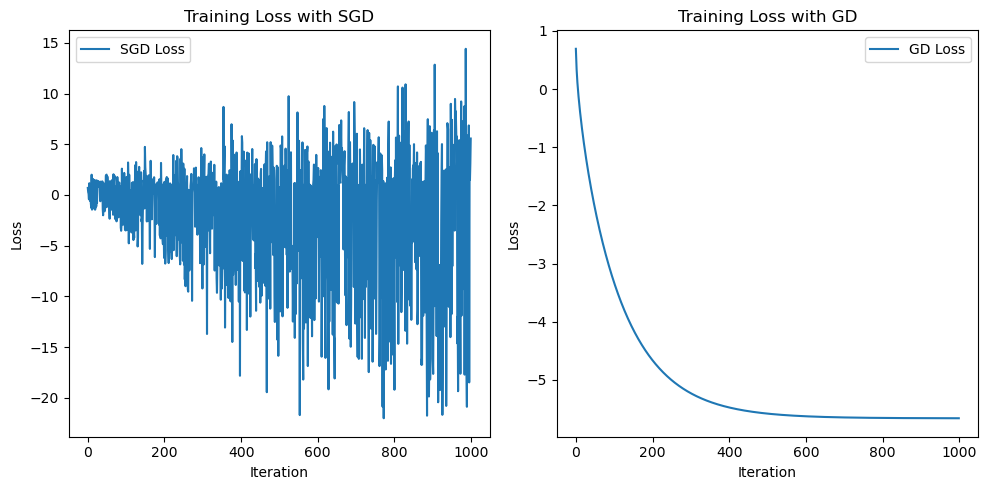

In [60]:

reg_par = 0.01    
maxiter = 1000      
learning_rate = 0.01 


w_sgd, losses_sgd = train_logreg_sgd(Xtr_wbias, Ytr, reg_par, maxiter=maxiter)


w_gd, losses_gd = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter)

iterations_sgd = len(losses_sgd)
iterations_gd = len(losses_gd)

print(f"SGD iterations to converge: {iterations_sgd}")
print(f"GD iterations to converge: {iterations_gd} (GD iteration costs {Xtr_wbias.shape[0]} times more)")

ts_pred_sgd, _ = predict_logreg(w_sgd, Xts_wbias)
ts_pred_gd, _ = predict_logreg(w_gd, Xts_wbias)

accuracy_sgd = np.mean(np.sign(ts_pred_sgd) == Yts) * 100
accuracy_gd = np.mean(np.sign(ts_pred_gd) == Yts) * 100


print(f"SGD Test Set Accuracy: {accuracy_sgd:.2f}%")
print(f"GD Test Set Accuracy: {accuracy_gd:.2f}%")


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_sgd, label="SGD Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss with SGD")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(losses_gd, label="GD Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss with GD")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
Iterations for Convergence: SGD usually requires more iterations than GD to converge. However, the iterations in the SGD method are much faster in nature.
This leaves accuracy: If the models have converged to good solutions, both methods should give similar accuracies, although there might be minor variations owing to the stochastic nature of SGD.